# Predicting Youth Mental Health Risk

Student: Michael Kamp  

## 1. Business Understanding

This notebook supports the final project for DATA 747 and focuses on predicting poor mental-health outcomes among U.S. high-school students using the 2019 CDC Youth Risk Behavior Surveillance System (YRBSS) dataset.

The goal of this analysis is to explore behavioral and demographic factors associated with the likelihood that a student reports persistent sadness or hopelessness (QN8). Using this dataset, we will prepare the data, conduct exploratory analysis, train supervised machine-learning models, and evaluate their predictive performance.

**Research Question:**  
What factors help predict whether a high-school student reports poor mental health (defined as persistent sadness/hopelessness for two or more weeks)?

**Notebook Roadmap**
1. **Data Understanding** – Review dataset structure and key variables.  
2. **Data Preparation** – Clean the data, handle missing values, and select variables.  
3. **Exploratory Data Analysis (EDA)** – Visualize distributions and relationships among features.  
4. **Modeling** – Train and evaluate logistic regression and decision-tree classifiers.  
5. **Model Evaluation** – Generate confusion matrices, ROC curves, and other performance metrics.



In [1]:
# SECTION 1 — DATA LOADING
import pandas as pd
import numpy as np
import re

data_file = "yrbs2019.dat"
sas_layout = "yrbs2019_input.sas"

# ---- Custom SAS parser (reads @start variable width.) ----
def parse_sas_input_pointer_format(file_path):
    colspecs = []
    names = []
    pattern = re.compile(r"@(\d+)\s+(\w+)\s+(\$?)(\d+)")

    with open(file_path, "r") as f:
        lines = f.readlines()

    entries = []
    for line in lines:
        match = pattern.search(line)
        if match:
            start = int(match.group(1)) - 1          # convert 1-based to 0-based index
            name = match.group(2)
            width = int(match.group(4))
            end = start + width
            entries.append((start, end, name))

    entries.sort(key=lambda x: x[0])

    for start, end, name in entries:
        colspecs.append((start, end))
        names.append(name)

    return colspecs, names

# ---- Parse SAS input layout ----
colspecs, names = parse_sas_input_pointer_format(sas_layout)
print("Columns detected:", len(names))

# ---- Load FIXED-WIDTH YRBS 2019 dataset ----
data = pd.read_fwf(data_file, colspecs=colspecs, names=names)

# Preview
print("First 10 rows:")
display(data.head(10))


Columns detected: 235
First 10 rows:


,SITE,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,...,QNILLICT,QNOBESE,QNOWT,WEIGHT,STRATUM,PSU,BMIPCT,RACEETH,Q6ORIG,Q7ORIG
0,XX,5.0,2.0,2.0,1.0,A,1.63,54.89,4.0,1.0,...,2.0,2.0,2.0,1.6659,213,57923,46.88,7.0,504,121
1,XX,4.0,2.0,2.0,2.0,A D,1.60,53.98,5.0,2.0,...,2.0,2.0,2.0,1.3851,213,57923,62.23,8.0,503,119
2,XX,4.0,1.0,2.0,2.0,B E,1.68,43.09,4.0,1.0,...,2.0,2.0,2.0,1.4958,213,57923,0.59,8.0,506,95
3,XX,4.0,2.0,2.0,2.0,E,1.78,68.95,4.0,1.0,...,1.0,2.0,2.0,1.7114,213,57923,69.79,5.0,510,152
4,XX,5.0,2.0,2.0,1.0,NaN,1.78,58.97,4.0,1.0,...,2.0,2.0,2.0,1.6659,213,57923,16.74,6.0,510,130
5,XX,4.0,1.0,2.0,2.0,E,1.68,74.84,4.0,1.0,...,1.0,2.0,1.0,1.8481,213,57923,91.80,5.0,506,165
6,XX,5.0,1.0,2.0,2.0,E,1.65,61.69,4.0,1.0,...,2.0,2.0,2.0,1.8481,213,57923,71.28,5.0,505,136
7,XX,4.0,2.0,2.0,2.0,E,1.88,77.11,5.0,1.0,...,1.0,2.0,2.0,1.7114,213,57923,70.34,5.0,602,170
8,XX,4.0,1.0,2.0,2.0,E,1.60,52.16,5.0,5.0,...,2.0,2.0,2.0,1.8481,213,57923,52.56,5.0,503,115
9,XX,5.0,2.0,2.0,1.0,A,1.68,51.71,2.0,1.0,...,2.0,2.0,2.0,1.6659,213,57923,13.24,7.0,506,114


## 2. Data Understanding

This section provides an initial examination of the 2019 CDC Youth Risk Behavior Surveillance System (YRBSS) dataset. The dataset contains a wide range of demographic, behavioral, and health-related variables reported by high-school students across the United States. Before preparing the data for modeling, it is essential to understand the structure, content, and quality of the dataset.

### Objectives of Data Understanding
1. **Confirm that the dataset loaded correctly** using the CDC SAS layout file to extract column positions and variable names.
2. **Review dataset structure**, including the number of rows, columns, and variable data types.
3. **Identify major characteristics of key demographic variables** such as sex (Q2), grade (Q3), and race/ethnicity (Q4).
4. **Examine the distribution of the mental-health target variable (QN8)**, which indicates whether a student felt sad or hopeless for two or more weeks.
5. **Assess missing data**, which is important because the YRBSS uses special numeric codes (e.g., 7, 8, 9, 77, 88, 99) to represent non-responses.
6. **Explore early distributions** of selected behavioral and health variables relevant to the research question.

### Why This Matters
A thorough understanding of the dataset ensures that the next step—data preparation—is performed accurately and effectively. Identifying missing values, variable types, and preliminary patterns informs decisions about cleaning, recoding, and selecting features for modeling.

The visualizations and summary statistics in this section help lay the foundation for exploratory data analysis and model development in later sections.


Preview of dataset:


,SITE,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,...,QNILLICT,QNOBESE,QNOWT,WEIGHT,STRATUM,PSU,BMIPCT,RACEETH,Q6ORIG,Q7ORIG
0,XX,5.0,2.0,2.0,1.0,A,1.63,54.89,4.0,1.0,...,2.0,2.0,2.0,1.6659,213,57923,46.88,7.0,504,121
1,XX,4.0,2.0,2.0,2.0,A D,1.60,53.98,5.0,2.0,...,2.0,2.0,2.0,1.3851,213,57923,62.23,8.0,503,119
2,XX,4.0,1.0,2.0,2.0,B E,1.68,43.09,4.0,1.0,...,2.0,2.0,2.0,1.4958,213,57923,0.59,8.0,506,95
3,XX,4.0,2.0,2.0,2.0,E,1.78,68.95,4.0,1.0,...,1.0,2.0,2.0,1.7114,213,57923,69.79,5.0,510,152
4,XX,5.0,2.0,2.0,1.0,NaN,1.78,58.97,4.0,1.0,...,2.0,2.0,2.0,1.6659,213,57923,16.74,6.0,510,130



Summary statistics:


,SITE,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,...,QNILLICT,QNOBESE,QNOWT,WEIGHT,STRATUM,PSU,BMIPCT,RACEETH,Q6ORIG,Q7ORIG
count,13677,13605.000000,13526.000000,13565.000000,13386.000000,12432,12140.000000,12140.000000,11149.000000,12817.000000,...,9793.000000,12140.000000,12140.000000,13677.000000,13677.000000,13677.000000,13677,13239.000000,12969,12574
unique,1,NaN,NaN,NaN,NaN,37,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4020,NaN,74,335
top,XX,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,.,NaN,506,120
freq,13677,NaN,NaN,NaN,NaN,8000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1537,NaN,1221,561
mean,NaN,4.936935,1.490980,2.405603,1.772598,NaN,1.692431,67.911062,4.301462,1.349614,...,1.834576,1.852142,1.840774,1.000001,158.629012,364602.951086,NaN,5.035275,NaN,NaN
std,NaN,1.241966,0.499937,1.102207,0.419170,NaN,0.102050,17.778548,0.992156,0.892837,...,0.371582,0.354974,0.365901,0.894236,50.792157,191089.627051,NaN,1.534430,NaN,NaN
min,NaN,1.000000,1.000000,1.000000,1.000000,NaN,1.300000,27.220000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.065000,101.000000,57923.000000,NaN,1.000000,NaN,NaN
25%,NaN,4.000000,1.000000,1.000000,2.000000,NaN,1.630000,55.340000,4.000000,1.000000,...,2.000000,2.000000,2.000000,0.331500,103.000000,173676.000000,NaN,5.000000,NaN,NaN
50%,NaN,5.000000,1.000000,2.000000,2.000000,NaN,1.680000,63.500000,5.000000,1.000000,...,2.000000,2.000000,2.000000,0.748000,201.000000,343880.000000,NaN,5.000000,NaN,NaN
75%,NaN,6.000000,2.000000,3.000000,2.000000,NaN,1.750000,75.750000,5.000000,1.000000,...,2.000000,2.000000,2.000000,1.360500,211.000000,515957.000000,NaN,6.000000,NaN,NaN



Data types:


SITE        object
Q1         float64
Q2         float64
Q3         float64
Q4         float64
            ...   
PSU          int64
BMIPCT      object
RACEETH    float64
Q6ORIG      object
Q7ORIG      object
Length: 235, dtype: object


Missing values in each column:


SITE          0
Q1           72
Q2          151
Q3          112
Q4          291
           ... 
PSU           0
BMIPCT        0
RACEETH     438
Q6ORIG      708
Q7ORIG     1103
Length: 235, dtype: int64


Unique values for categorical variables:
Q2: [ 2.  1. nan]
Q3: [ 2.  3.  4.  1. nan  5.]
Q6: [1.63 1.6  1.68 1.78 1.65 1.88 1.83 1.57 1.52 1.75 1.55 1.73 1.7   nan
 1.8  1.9  1.5  1.85 1.42 1.93 1.37 1.47 1.96 1.45 1.98 2.01 1.35 1.32
 2.03 1.3  1.4 ]
RACEETH: [ 7.  8.  5.  6.  1. nan  3.  2.  4.]


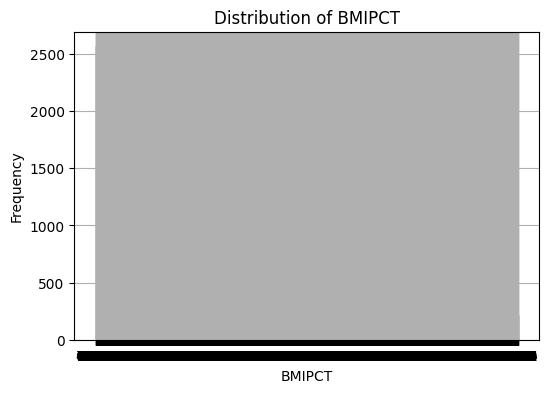

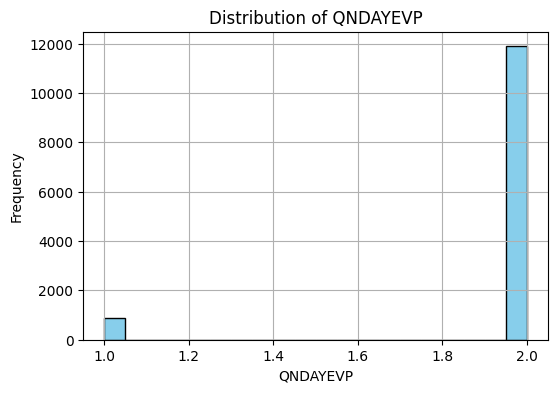

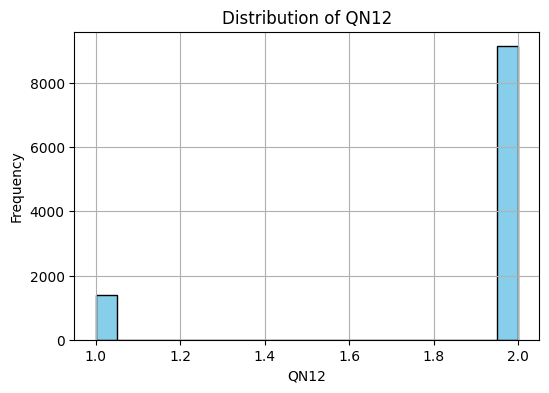

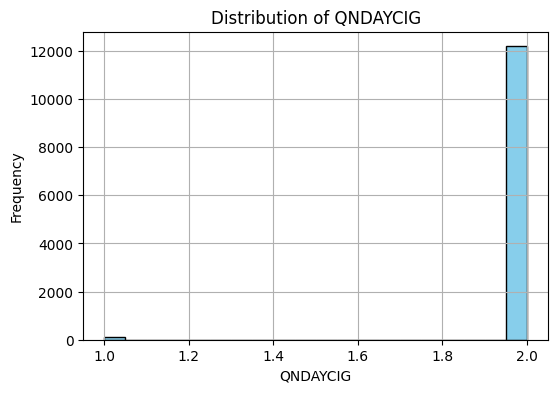

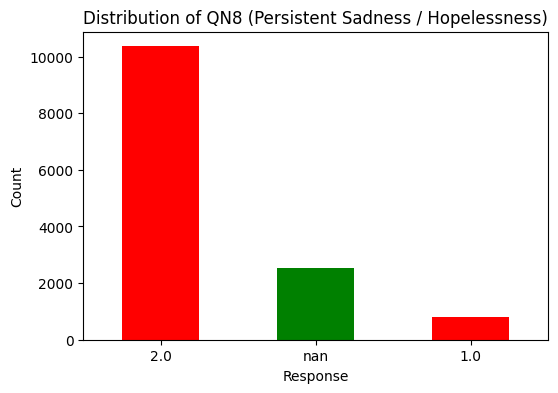

In [2]:
# DATA UNDERSTANDING
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print("Preview of dataset:")
display(data.head())

# Summary statistics
print("\nSummary statistics:")
display(data.describe(include='all'))

# Data types
print("\nData types:")
display(data.dtypes)

# Missing values
print("\nMissing values in each column:")
display(data.isnull().sum())

# Examine unique values in key demographic variables
categorical_cols = ['Q2', 'Q3', 'Q6', 'RACEETH']

print("\nUnique values for categorical variables:")
for col in categorical_cols:
    if col in data.columns:
        print(f"{col}: {data[col].unique()}")

# Explore distributions of important numeric variables
numeric_cols = ['BMIPCT', 'QNDAYEVP', 'QN12', 'QNDAYCIG']

for col in numeric_cols:
    if col in data.columns:
        plt.figure(figsize=(6,4))
        data[col].hist(bins=20, color='skyblue', edgecolor='black')
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.show()

# Target variable distribution (QN8: sad/hopeless 2+ weeks)
if 'QN8' in data.columns:
    plt.figure(figsize=(6,4))
    data['QN8'].value_counts(dropna=False).plot(kind='bar', color=['red','green'])
    plt.title("Distribution of QN8 (Persistent Sadness / Hopelessness)")
    plt.xlabel("Response")
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.show()


## 3. Data Preparation

This section prepares the YRBSS dataset for modeling by cleaning the data, selecting relevant variables, handling missing values, encoding categorical fields, and splitting the data into training and testing sets. Because the dataset is stored in a fixed-width format and includes CDC-coded missing values, several preprocessing steps are required before fitting machine-learning models.

### Objectives of Data Preparation
1. **Clean and standardize the dataset** by replacing CDC-coded missing values with `NaN`.
2. **Select the variables most relevant to predicting mental-health outcomes**, including demographic, behavioral, and health indicators.
3. **Convert categorical variables** (e.g., sex, grade, age group, race/ethnicity) into appropriate data types.
4. **Transform categorical fields using one-hot encoding** so they can be used by machine-learning algorithms.
5. **Drop incomplete rows** to ensure a consistent and reliable modeling dataset.
6. **Separate features (X) from the target variable (y)** and prepare them for model training.
7. **Scale numeric predictors** using StandardScaler for the logistic regression model.
8. **Create a train–test split** using stratified sampling to preserve the distribution of the mental-health outcome.

### Why These Steps Are Necessary
The YRBSS dataset uses a mixture of coded categorical values and non-standard missing-data indicators. Preparing the data properly ensures that:

- the machine-learning models receive consistent and meaningful inputs,
- categorical variables are encoded without introducing bias,
- scaled variables improve optimization for logistic regression,
- and the training/testing evaluation reflects the true distribution of mental-health outcomes.

At the end of this section, the dataset is fully prepared for modeling using logistic regression and decision-tree classifiers.


In [3]:
# DATA PREPARATION

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# 1. Replace CDC-coded missing values with NaN
coded_missing = [7, 8, 9, 77, 88, 99]
data = data.replace(coded_missing, np.nan)

# 2. Select relevant variables for modeling
selected_columns = [
    'Q2',          # Sex
    'Q3',          # Grade
    'Q6',          # Age category
    'RACEETH',     # Race / Ethnicity

    'QN8',         # Target: sad/hopeless ≥2 weeks

    'QN12',        # Alcohol use
    'QNDAYEVP',    # E-cigarette use (days)
    'QNDAYCIG',    # Cigarette use (days)
    'QNSODA1',     # Soda consumption
    'QNPA0DAY',    # No physical activity
    'QNOBESE',     # Obesity status
    'BMIPCT'       # BMI percentile
]

selected_columns = [c for c in selected_columns if c in data.columns]
cleaned = data[selected_columns].copy()

# 3. Convert demographic variables to categorical
categorical_vars = ['Q2', 'Q3', 'Q6', 'RACEETH']

for col in categorical_vars:
    if col in cleaned.columns:
        cleaned[col] = cleaned[col].astype('category')

# 4. Convert remaining variables to numeric
for col in cleaned.columns:
    if col not in categorical_vars:
        cleaned[col] = pd.to_numeric(cleaned[col], errors='coerce')

# 5. Drop rows with missing values for modeling
rows_before = cleaned.shape[0]
cleaned = cleaned.dropna()
rows_after = cleaned.shape[0]

print(f"Rows before dropping missing values: {rows_before}")
print(f"Rows after dropping missing values:  {rows_after}")
print(f"Total rows removed:                  {rows_before - rows_after}")

# 6. Split into features (X) and target (y)
y = (cleaned['QN8'] == 1).astype(int)
X = cleaned.drop('QN8', axis=1)

# 7. One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)

print("Shape after encoding:", X.shape)

# 8. Train/Test Split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Training target distribution:")
print(y_train.value_counts(normalize=True))

# 9. Standard Scaling (Logistic Regression only)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nScaling complete.")
print("Scaled X_train shape:", X_train_scaled.shape)
print("Scaled X_test shape:", X_test_scaled.shape)


Rows before dropping missing values: 13677
Rows after dropping missing values:  5760
Total rows removed:                  7917
Shape after encoding: (5760, 46)
Training set shape: (4320, 46)
Testing set shape: (1440, 46)
Training target distribution:
QN8
0    0.950231
1    0.049769
Name: proportion, dtype: float64

Scaling complete.
Scaled X_train shape: (4320, 46)
Scaled X_test shape: (1440, 46)


In [4]:
## 4. Exploratory Data Analysis (EDA)

This section explores the structure and key characteristics of the variables included in the study. Exploratory Data Analysis helps identify patterns,
trends, and potential relationships in the dataset prior to modeling. Because the YRBSS includes a broad range of demographic, behavioral,and health variables,
EDA is essential for understanding which factors may be associated with poor mental-health outcomes.

### Objectives of EDA
1. **Examine the distribution of demographic variables**, including sex (Q2), grade level (Q3), and race/ethnicity (Q4), to understand population composition.
2. **Visualize the distribution of the target variable (QN8)**, which indicates whether a student experienced persistent sadness or hopelessness.
3. **Explore behavioral indicators** such as alcohol use, vaping, smoking, soda consumption, and physical inactivity.
4. **Compare mental-health outcomes across demographic and behavioral subgroups** using side-by-side count plots.
5. **Generate a correlation heatmap** to identify relationships among numeric variables, such as BMI percentile and behavioral frequency indicators.

### Why This Matters
EDA provides an essential foundation for modeling. Visualizing these variables allows us to quickly identify imbalances, unusual values, and potential predictors. 
Understanding how mental-health outcomes vary across demographic and behavioral groups helps guide feature selection and interpret model performance in later sections.

The visualizations in this section highlight important structures within the dataset and support the development of more effective predictive models.


SyntaxError: invalid syntax (253373735.py, line 3)

In [ ]:
# Exploratory Data Analysis (with plot saving)

import matplotlib.pyplot as plt
import seaborn as sns
import os

# Ensure folder exists
os.makedirs("plots", exist_ok=True)

print("Dataset shape:", data.shape)

# Summary Statistics

display(data.describe(include='all'))
display(data.dtypes)


# Demographic Distributions
demo_vars = ["Q2", "Q3", "Q4"]

for col in demo_vars:
    if col in data.columns:
        plt.figure(figsize=(6,4))
        data[col].value_counts(dropna=False).plot(kind="bar", color="steelblue")
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Count")

        # Save chart
        plt.savefig(f"plots/EDA_distribution_{col}.png", dpi=300, bbox_inches='tight')
        plt.show()


# Missing Data Chart
missing = data.isnull().sum().sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=missing.head(20).index, y=missing.head(20).values, palette="viridis")
plt.xticks(rotation=90)
plt.title("Top Missing Variables")
plt.tight_layout()

plt.savefig("plots/EDA_missing_values.png", dpi=300, bbox_inches='tight')
plt.show()

# Numeric Variable Distributions
numeric_cols = ['BMIPCT', 'QNDAYEVP', 'QN12', 'QNDAYCIG']

for col in numeric_cols:
    if col in data.columns:
        plt.figure(figsize=(6,4))
        data[col].hist(bins=20, color="lightgreen", edgecolor="black")
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")

        plt.savefig(f"plots/EDA_numeric_{col}.png", dpi=300, bbox_inches='tight')
        plt.show()

# Target Variable (QN8)
if "QN8" in data.columns:
    plt.figure(figsize=(6,4))
    data["QN8"].value_counts(dropna=False).plot(kind="bar", color=["red","green"])
    plt.title("Distribution of QN8 (Sad/Hopeless 2+ Weeks)")
    plt.xlabel("Response")
    plt.ylabel("Count")
    plt.xticks(rotation=0)

    plt.savefig("plots/EDA_target_QN8.png", dpi=300, bbox_inches='tight')
    plt.show()


## 5. Modeling

In this section, we build predictive models to identify factors associated with poor mental-health outcomes among high-school students. Using the cleaned and prepared dataset from the previous section, we apply two supervised machine-learning algorithms:

1. **Logistic Regression** – A linear classification model used as a baseline to predict the likelihood that a student reports persistent sadness or hopelessness (QN8). Logistic regression is effective when the relationship between predictors and the target variable is approximately linear and when interpretability is important.

2. **Decision Tree Classifier** – A non-linear model capable of capturing complex interactions between demographic, behavioral, and health variables. Decision trees can identify the most influential predictors by recursively splitting the dataset into meaningful subgroups.

### Modeling Workflow
- The dataset is split into training and testing sets using stratified sampling to preserve the distribution of the mental-health outcome.
- Logistic regression is trained on **scaled** inputs to improve stability and performance.
- The decision-tree classifier is trained on **unscaled** inputs, since tree-based models are not sensitive to feature scaling.
- Each model generates predictions on the testing set and is evaluated using accuracy, precision, recall, F1-score, and a classification report.

### Purpose of This Section
By fitting both a linear and a non-linear model, we can compare performance and better understand the predictive structure of the YRBSS dataset. This provides insight into which model is best suited for identifying students at elevated mental-health risk.


In [ ]:
# MODELING: Logistic Regression and Decision Tree Classifier

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
)

print("=== MODELING SECTION ===\n")


# Logistic Regression (uses scaled features)
log_model = LogisticRegression(max_iter=500, solver="lbfgs")
log_model.fit(X_train_scaled, y_train)

# Predictions
log_pred = log_model.predict(X_test_scaled)

# Evaluation
log_accuracy = accuracy_score(y_test, log_pred)
print(f"Logistic Regression Accuracy: {log_accuracy:.4f}")
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, log_pred))

# Decision Tree Classifier (uses unscaled features)
tree_model = DecisionTreeClassifier(
    criterion="gini",
    max_depth=None,
    random_state=42
)

tree_model.fit(X_train, y_train)

# Predictions
tree_pred = tree_model.predict(X_test)

# Evaluation
tree_accuracy = accuracy_score(y_test, tree_pred)
print(f"Decision Tree Accuracy: {tree_accuracy:.4f}")
print("\nDecision Tree Classification Report:")
print(classification_report(y_test, tree_pred))


# Model Comparison Summary
print("=== MODEL COMPARISON SUMMARY ===")
print(f"Logistic Regression Accuracy: {log_accuracy:.4f}")
print(f"Decision Tree Accuracy:      {tree_accuracy:.4f}")



## 6. Model Evaluation

After training the logistic regression and decision-tree models, this section evaluates their performance on the testing dataset. Model evaluation provides insight into how effectively each classifier identifies students who report poor mental-health outcomes and how well the models generalize to new, unseen data.

### Evaluation Metrics

To assess each model, we use several common classification performance measures:

- **Confusion Matrix:**  
  Displays true positives, true negatives, false positives, and false negatives.  
  This helps identify how often each model correctly classifies students with and without reported sadness/hopelessness.

- **Classification Report:**  
  Includes precision, recall, F1-score, and support for each class.  
  These metrics are especially important given the imbalance in mental-health outcomes.

- **ROC Curve (Receiver Operating Characteristic):**  
  Shows the trade-off between the true positive rate and false positive rate across different thresholds.

- **AUC (Area Under the Curve):**  
  Summarizes how well a model distinguishes between students who reported persistent sadness and those who did not.  
  Higher AUC values indicate stronger discriminative ability.

- **Feature Importance (Decision Tree):**  
  Highlights which demographic, behavioral, or health-related factors contribute most strongly to the decision-tree model’s predictions.

### Purpose of This Section
This evaluation helps determine which model performs best and provides insight into the patterns within the dataset. Understanding model strengths and weaknesses supports the interpretation of results in the accompanying APA report.


In [ ]:
#  MODEL EVALUATION (Saved Plots)

import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    roc_auc_score
)

# Ensure plots/ folder exists
os.makedirs("plots", exist_ok=True)

print("=== MODEL EVALUATION SECTION ===\n")

# 1. CONFUSION MATRICES
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Logistic Regression
ConfusionMatrixDisplay.from_estimator(
    log_model, X_test_scaled, y_test,
    cmap="Blues", ax=axes[0]
)
axes[0].set_title("Logistic Regression – Confusion Matrix")

# Decision Tree
ConfusionMatrixDisplay.from_estimator(
    tree_model, X_test, y_test,
    cmap="Greens", ax=axes[1]
)
axes[1].set_title("Decision Tree – Confusion Matrix")

plt.tight_layout()
plt.savefig("plots/confusion_matrices.png", dpi=300, bbox_inches='tight')
plt.show()

print("Saved: plots/confusion_matrices.png")

# 2. ROC CURVES + AUC
plt.figure(figsize=(8, 6))

# AUC values
log_auc = roc_auc_score(y_test, log_model.predict_proba(X_test_scaled)[:, 1])
tree_auc = roc_auc_score(y_test, tree_model.predict_proba(X_test)[:, 1])

# ROC curves
RocCurveDisplay.from_estimator(
    log_model, X_test_scaled, y_test,
    name=f"Logistic Regression (AUC = {log_auc:.2f})",
    color="blue"
)

RocCurveDisplay.from_estimator(
    tree_model, X_test, y_test,
    name=f"Decision Tree (AUC = {tree_auc:.2f})",
    color="green"
)

# Random baseline
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")

# Determine best model
best_model_name = "Logistic Regression" if log_auc > tree_auc else "Decision Tree"
best_model_auc = max(log_auc, tree_auc)

# Add annotation box
plt.text(
    0.60, 0.15,
    f"Best Model: {best_model_name}\nAUC = {best_model_auc:.2f}",
    fontsize=12,
    bbox=dict(facecolor="white", edgecolor="black", alpha=0.85)
)

plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(alpha=0.3)

plt.savefig("plots/roc_curve_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print("Saved: plots/roc_curve_comparison.png")

# 3. DECISION TREE FEATURE IMPORTANCE
importances = tree_model.feature_importances_
feature_names = X_train.columns

imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(
    data=imp_df.head(20),
    x="Importance", y="Feature",
    palette="viridis"
)

plt.title("Top 20 Feature Importances – Decision Tree")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()

plt.savefig("plots/decision_tree_feature_importances.png", dpi=300, bbox_inches='tight')
plt.show()

print("Saved: plots/decision_tree_feature_importances.png")

print("\n=== MODEL EVALUATION COMPLETE ===")
print(f"Logistic Regression AUC: {log_auc:.4f}")
print(f"Decision Tree AUC:       {tree_auc:.4f}")
